Trey's fine imports

In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as cf

NetCDF4 file reading stuffs

In [2]:
#ERA5 files
eraf1 = "ERA5comparisonData/prt_1971_2000_ERA5_monthly_T42.nc"


#PlaSim output files
file1   = "PLASIMoutputData/gmst_r0hv1_yrmean.nc"
file2   = 'PLASIMoutputData/gmst_r0hv2_yrmean.nc'
file3   = 'PLASIMoutputData/gmst_r0hv3_yrmean.nc'         

file_list = [file1, file2, file3]

#sizing stuffs
fileListLen = len(file_list)
##grabbing the size info from one file to know the number of years
a = nc.Dataset(file1)
b = a.variables['time'][:]
fileLen = len(b)

In [3]:
#empty array creation, expecting 3 files in the list
dataRRay = np.zeros((fileLen, 2, fileListLen))

#loop over the datasets to read them into an array. Each file becomes a 2d slice of the 3d array like [year in hrs, dataPt]
for datasetNum in range(len(file_list)):
    #grabbing individual dataset
    set = nc.Dataset(file_list[datasetNum])

    #getting the data into the array, line by line
    for dataPt in range(fileLen):

        #convert the time format from hours to years
        timeInHrs = set.variables['time'][dataPt]
        if timeInHrs/8652 < 1:
            timeInYrs = 0
        else:
            timeInYrs = np.round(timeInHrs/8652)

        #fill years into the 0th array column
        dataRRay[dataPt, 0, datasetNum] = timeInYrs

        #fill in temp data to the 1st col of array
        dataRRay[dataPt, 1, datasetNum] = set.variables['tas'][dataPt]

#avg of the ensemble members for later comparison
avgDataArr = np.average(dataRRay, axis=2)

Sanity check plots

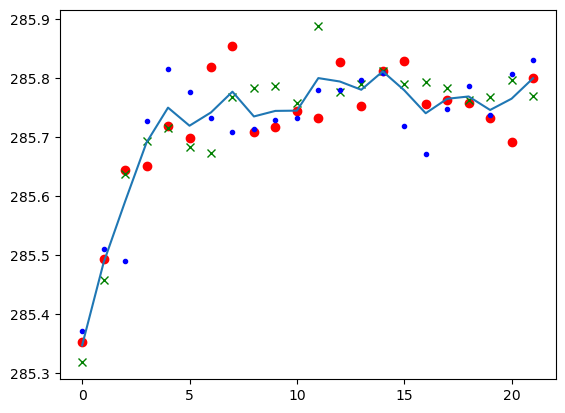

In [4]:
plt.plot(dataRRay[:,0,0], dataRRay[:,1,0], "or")
plt.plot(dataRRay[:,0,1], dataRRay[:,1,1], "xg")
plt.plot(dataRRay[:,0,2], dataRRay[:,1,2], ".b")
plt.plot(avgDataArr[:,0], avgDataArr[:,1])
plt.show()

#print(dataRRay[:,:,0])

Actual 'emulation' calculation stuff

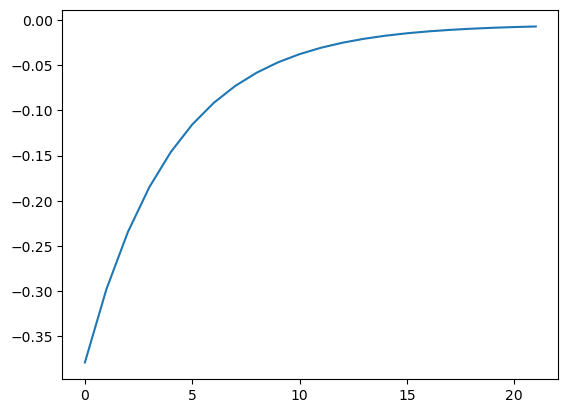

In [5]:
#consts and vars
k = 3.74 #W/m^2 forcing const
t = int(fileLen) #years in a file
# tau = 0 #year to start
# x = t - tau #number of years ago the forcing occured

#CO2 reference amount
seaOhTwo = 285 #ppm

#standard settings !!!
q1 = 0.33 #K/(W/m^2)
q2 = 0.41 #K/(W/m^2)
d1 = 239 #years
d2 = 4.1 #years
paramList = [q1, q2, d1, d2]

#CO2 ref array creation and population, rows: [time, concentration]
co2_0 = np.ones((t, 2), dtype=float)
#set the data to the ref value
co2_0[:,1] *= seaOhTwo
#fix the first year
co2_0[0,0] = 0.0
#fix the rest of the years
for yr in range(1, t):
    co2_0[yr,0] = yr


#CO2 half pulse at t=0 array
co2HF = np.array(co2_0)
co2HF[0,1] = 0.5*seaOhTwo
#so year 0 has half of the CO2 concentration of the other years

#CO2 doubling pulse arr
co2dub = np.array(co2_0)
co2dub[0,1] += seaOhTwo

#CO2 quadrupling arr
co2quad = np.array(co2_0)
co2quad[0,1] += 3*seaOhTwo


#Response and rad forcing in one func
def WomboCombo(xData, que1, que2, dee1, dee2):
###################
#x = t #len(xData)
# que1 = q1
# que2 = q2
# dee1 = d1
# dee2 = d2
# c = co2HF[:,1]
###################
    #changes to different concentration array cases based on the c arg
    global c
        
    #Clear out summa for next run
    summa = np.zeros(t, dtype=float)
    
    #forcing_0
    F = (3.74/np.log(2))*np.log(c[0]/seaOhTwo)
    
    #print("F:" + str(F))
    
    #Calculate the sum
    for i in range(0,t):
    
        #print("R:" + str((que1/dee1)*np.exp(-i/dee1)+(que2/dee2)*np.exp(-i/dee2)))
            
        ##########Rad Forcing "F"                           #Response func "R"
        summa[i] = F * ((que1/dee1)*np.exp(-i/dee1)+(que2/dee2)*np.exp(-i/dee2))
            
        #print("sum: " +str(summa[i]))
    return summa
    
#idiot check
c = co2HF[:,1]
plt.plot(WomboCombo(avgDataArr[:,0], paramList[0], paramList[1], paramList[2], paramList[3]))

Optimization code

OG Params: [0.33, 0.41, 239, 4.1]
updated: [5.95909483e+05 2.39734571e-01 8.41366945e+07 2.05941866e+00]


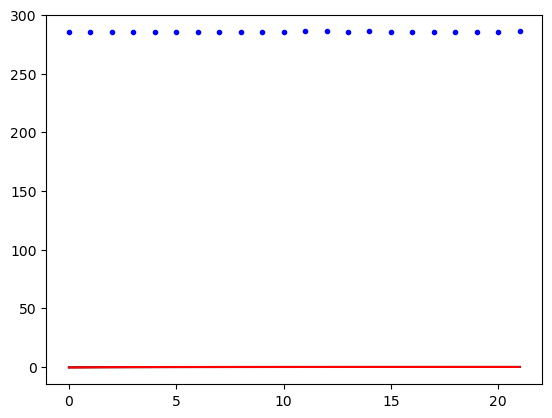

In [11]:
#functionalize this for calling for each pulse type

c = co2HF[:,1]
optParamsHalf, covarMat = cf(WomboCombo, avgDataArr[:,0], avgDataArr[:,1]-285.8, p0=paramList, method="dogbox")
#print(optParamsHalf)

# c = co2dub[:,1]
# optParamsDub, covarMat = cf(WomboCombo, avgDataArr[:,0], avgDataArr[:,1], paramList)
# #print("\n" + str(optParamsDub))

# c = co2quad[:,1]
# optParamsQuad, covarMat = cf(WomboCombo, avgDataArr[:,0], avgDataArr[:,1], paramList)
# #print("\n" + str(optParamsQuad))


#sanity checking that all of the parameters are the same for real
print("OG Params: " +str(paramList))
print('updated: ' + str(optParamsHalf))


plt.plot(avgDataArr[:,0], WomboCombo(avgDataArr[:,0], paramList[0], paramList[1], paramList[2], paramList[3]), "-k")
plt.plot(avgDataArr[:,0], WomboCombo(avgDataArr[:,0], optParamsHalf[0], optParamsHalf[1], optParamsHalf[2], optParamsHalf[3]), "-r")
plt.plot(avgDataArr[:,0], avgDataArr[:,1], ".b")
plt.show()

In [15]:
#ECS and TCR calculation
ECS = k*(q1+q2)

TCR = k*(q1*(1-(d1/70)*(1-np.exp(-70/d1)))) + q2*(1-(d2/70)*(1-np.exp(-70/d2)))

RWF = str(TCR/ECS)
print("RWF " + RWF)

RWF 0.1988367806493399
